# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
plt.style.use('ggplot')

COLOR_FEMALE = cm.get_cmap("RdBu")(220) # set blue for female
COLOR_MALE = cm.get_cmap("RdBu")(35) # set red for male
TITLE_SIZE = 22
TITLE_PADDING = 10

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [12, 5],
   }
plt.rcParams.update(params)

import pandas as pd
pd.options.display.max_rows = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

import copy
import os
import sys
import glob
from shutil import copyfile
import time
from tabulate import tabulate
from tqdm.notebook import tqdm

In [2]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score

from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
set_config(display='diagram')

import umap 

In [3]:
import librosa
import librosa.display

import pydub
from pydub import AudioSegment, effects

# 1) Training first models

I load the prepared data, shuffle and split a test set.

In [4]:
def load_prepared_data(language, split=True, n_samples=5_000):
    df_meta = pd.read_parquet(f"_saved_features/_features_step01/cv_{language}_meta.parq")
    df_features = pd.read_parquet(f"_saved_features/_features_step01/cv_{language}_features.parq")
    df_fO = pd.read_parquet(f"_saved_features/_features_step01/cv_{language}_fO.parq")

    # shuffling the data
    df_meta = df_meta.sample(len(df_meta), random_state=42).reset_index(drop=True)
    df_features = df_features.sample(len(df_features), random_state=42).reset_index(drop=True)
    df_fO = df_fO.sample(len(df_fO), random_state=42).reset_index(drop=True)
    if "man" in df_fO.columns:
        df_fO.drop("man", axis=1, inplace=True)

    # split STFT and MFCC
    df_stft = df_features.iloc[:, :1025].copy()
    df_mfcc = df_features.iloc[:, 1025:].copy()
    
    converted_mel_bands_to_Hz = librosa.mel_frequencies(n_mels=80, fmin=60, fmax=8000)
    df_mfcc.columns = [f"{x:.0f}" + "_Hz" for x in converted_mel_bands_to_Hz]

    # combine FO, STFT and MFCC features
    df_features = pd.concat([df_fO, df_mfcc, df_stft], axis=1).reset_index(drop=True)
    # dropping a couple of recordings for which FO couldn't be calculated 
    df_features.dropna(inplace=True)
    df_meta = df_meta.loc[df_features.index]

    df_meta.reset_index(drop=True, inplace=True)
    df_features.reset_index(drop=True, inplace=True)
    
    # again make sure we have a balanced data set gender wise
    female = df_meta[df_meta.gender=="female"]
    male = df_meta[df_meta.gender=="male"]
    if len(female)<len(male):
        male = male.sample(len(female))
    elif len(female)>len(male):
        female = female.sample(len(male))
    df_meta = pd.concat([male, female])
    df_features = df_features.loc[df_meta.index]

    df_meta.reset_index(drop=True, inplace=True)
    df_features.reset_index(drop=True, inplace=True)
    
    if split==True:
        # splitting a train and test set
        X_train, X_test, y_train, y_test = train_test_split(df_features, 
                                                            df_meta, 
                                                            test_size=n_samples, 
                                                            random_state=42, 
                                                            stratify=df_meta.gender
                                                            )
    
        return X_train, X_test, y_train, y_test
    
    else:
        return df_features, df_meta 

In [5]:
df_features_train, df_features_test, df_meta_train, df_meta_test = load_prepared_data("_german")
feat_gr, meta_gr  = load_prepared_data("_german", split=False)
feat_fr, meta_fr  = load_prepared_data("_french", split=False)
feat_it, meta_it  = load_prepared_data("_italian", split=False)
feat_ro, meta_ro  = load_prepared_data("_romansh", split=False)

Making sure I still have a balanced data set. 

In [6]:
print(df_meta_train.gender.value_counts())
print(meta_gr.gender.value_counts())
print(meta_fr.gender.value_counts())
print(meta_it.gender.value_counts())
print(meta_ro.gender.value_counts())

male      15033
female    15033
Name: gender, dtype: int64
male      17533
female    17533
Name: gender, dtype: int64
male      17777
female    17777
Name: gender, dtype: int64
male      7885
female    7885
Name: gender, dtype: int64
male      230
female    230
Name: gender, dtype: int64


To iterate faster I setup a function that separates features and target, splits train and test set, trains with a pipeline, prints out scores, classification report and confusion matrix.

In [7]:
def train_model(X_train, y_train, X_test, y_test, cv_folds=5,
                clf=DummyClassifier(), report=True, pca_STFT=True):
    
    if pca_STFT==True:
        # apply PCA to STFT features with column transformer
        col_trans = make_column_transformer([PCA(40), list(range(85,1110))], remainder="passthrough")
        pipe = make_pipeline(StandardScaler(), col_trans, clf)
    else:
        pipe = make_pipeline(StandardScaler(), clf)   
    
    scores = cross_val_score(pipe, X_train, y_train, cv=cv_folds, n_jobs=-1)
    print(f"{np.mean(scores):.3f} accuracy crossvalidated {cv_folds}fold")

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"{accuracy_score(y_test, y_pred):.3f} accuracy on test set")
    print()
    
    if report == True:
        print(classification_report(y_test, y_pred, zero_division=False))

        cfmtrx = confusion_matrix(y_test, y_pred, normalize="true")
        display(pd.DataFrame(cfmtrx, 
                     index=[x + "_true" for x in y_train.unique()],
                     columns=[x + "_pred" for x in y_train.unique()]
                    ))
        
    return y_test, y_pred

## Baseline with dummy classifier
Validating the data processing pipeline with a dummy classifier yields an accuracy of 0.5 (as is to be expected with two classes).

In [8]:
_, _ = train_model(df_features_train, df_meta_train.gender, 
                   df_features_test, df_meta_test.gender)

0.500 accuracy crossvalidated 5fold
0.500 accuracy on test set

              precision    recall  f1-score   support

      female       0.50      1.00      0.67      2500
        male       0.00      0.00      0.00      2500

    accuracy                           0.50      5000
   macro avg       0.25      0.50      0.33      5000
weighted avg       0.25      0.50      0.33      5000



,female_pred,male_pred
female_true,1.0,0.0
male_true,1.0,0.0


## Finding the best number of components with PCA
- **Reducing the dimensions of the combined features doesn't seem to substantially improve model training** of an untuned Logistic regressor. 
- I therefore decide to stick with the full feature set.

In [9]:
results = []
rng = range(1, 126, 5)

for n_components in tqdm(rng):
    # reduce STFT to 40 components, otherwise calculation takes very long
    col_trans = make_column_transformer([PCA(40), list(range(85,1110))], remainder="passthrough")
    pipe = make_pipeline(StandardScaler(), 
                         col_trans,
                         PCA(n_components=n_components, random_state=42), 
                         LogisticRegression(),
                         )
    scores = cross_val_score(pipe, feat_gr, meta_gr.gender, n_jobs=-1)
    results.append(np.mean(scores))

pipe = make_pipeline(StandardScaler(), col_trans, LogisticRegression())
scores_no_pca = cross_val_score(pipe, feat_gr, meta_gr.gender, n_jobs=-1)

  0%|          | 0/25 [00:00<?, ?it/s]

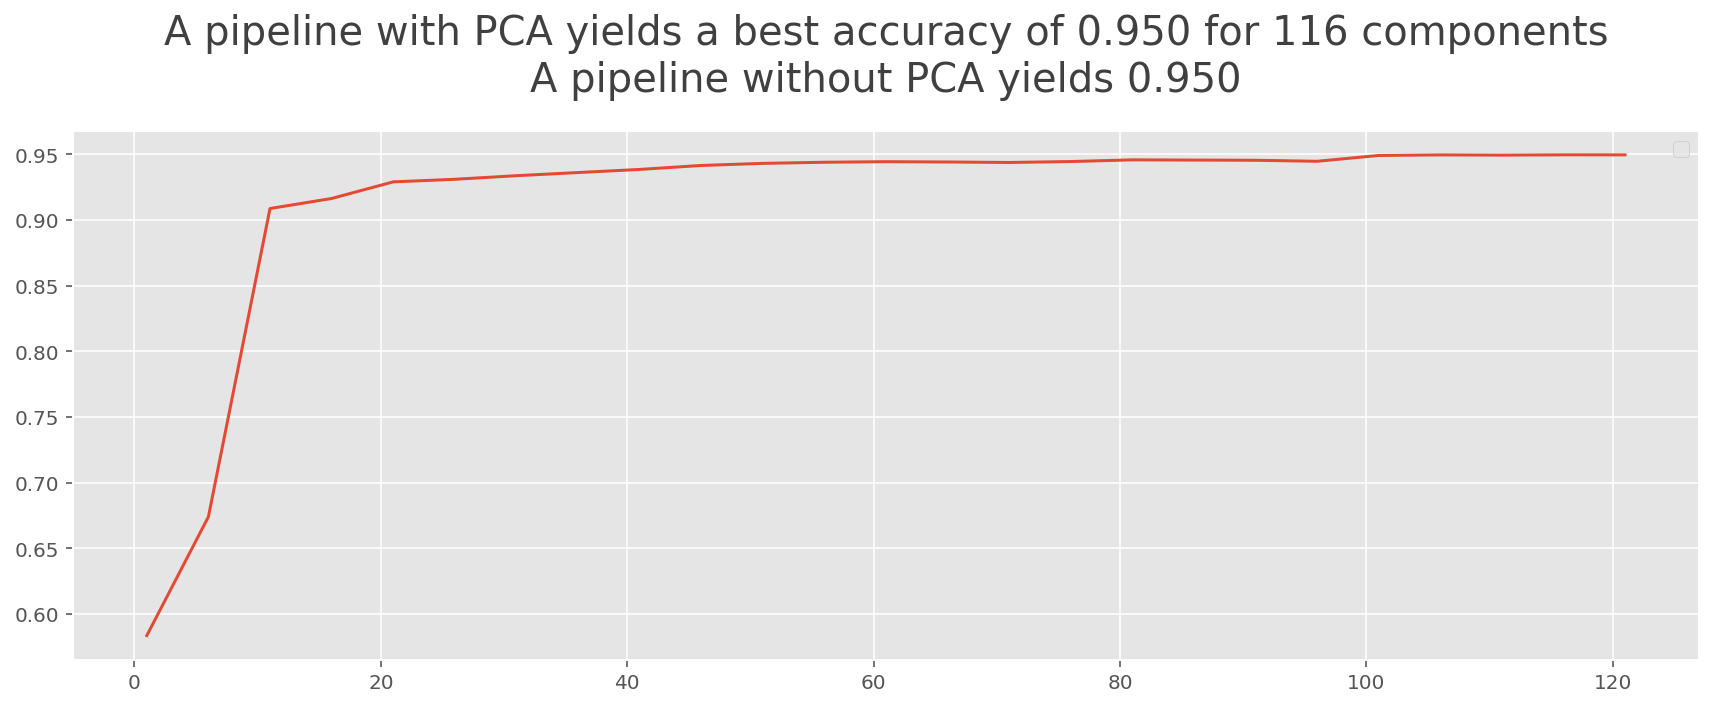

In [10]:
tmp = pd.DataFrame(results, index=rng, columns=["accuracy"])
best_score = tmp.accuracy.max()
best_n_components = tmp.accuracy.idxmax()
plt.figure(figsize=(12,5))
sns.lineplot(data=tmp)
plt.title(f"A pipeline with PCA yields a best accuracy of {best_score:.3f} for {best_n_components} components\nA pipeline without PCA yields {np.mean(scores_no_pca):.3f}",
         fontsize=20, pad=20)
plt.legend("")
plt.tight_layout()
plt.show()

## Baseline models with Logistic regression

### Training on various combinations of FO, MFCC and STFT
- Training an untuned Logistic regression classifier on just the mean FO yields 0.937 accuracy on the test set. This indicates that the **FO indeed is a powerful predicting feature.**
- **Using the FO statistics and the MFCC yields the best result on the test set (0.95).**
- **I decide to remove the STFTs since they actually seem to hurt the models quality.**
- I can imagine that the STFTs are too similar to the MFCCs in the way that they represent the amplitude of signal throughout the frequency spectrum. This might bring in some colinearity that degrades at least the logistic regression model.

In [11]:
MAX_ITER = 1e5

print("Training on only the median FO")
_, _ = train_model(df_features_train.iloc[:, 1:2], df_meta_train.gender, 
                   df_features_test.iloc[:, 1:2], df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False, 
                   pca_STFT=False)

print("Training on all FO statistics")
_, _ = train_model(df_features_train.iloc[:, :5], df_meta_train.gender, 
                   df_features_test.iloc[:, :5], df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False, 
                   pca_STFT=False)

print("Training on MFCC features")
_, _ = train_model(df_features_train.iloc[:, 5:85], df_meta_train.gender, 
                   df_features_test.iloc[:, 5:85], df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False, 
                   pca_STFT=False)

print("Training on STFT features")
_, _ = train_model(df_features_train.iloc[:, 85:], df_meta_train.gender, 
                   df_features_test.iloc[:, 85:], df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False, 
                   pca_STFT=False, 
                   cv_folds=3)

print("Training on MFCC and STFT features")
_, _ = train_model(df_features_train.iloc[:, 5:], df_meta_train.gender, 
                   df_features_test.iloc[:, 5:], df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False, 
                   pca_STFT=False, 
                   cv_folds=3)

def get_fO_and_mfcc(data):
    tmp = data[["fO_mean", "fO_median", "fO_min"]]
    return pd.concat([tmp, data.iloc[:, 5:85]], axis=1)

print("Training on reduced FO (mean, median, min) and MFCC features")
_, _ = train_model(get_fO_and_mfcc(df_features_train), df_meta_train.gender, 
                   get_fO_and_mfcc(df_features_test), df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False, 
                   pca_STFT=False)

print("Training on all FO and MFCC features")
_, _ = train_model(df_features_train.iloc[:, :85], df_meta_train.gender, 
                   df_features_test.iloc[:, :85], df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False, 
                   pca_STFT=False)

Training on only the median FO
0.933 accuracy crossvalidated 5fold
0.937 accuracy on test set

Training on all FO statistics
0.934 accuracy crossvalidated 5fold
0.936 accuracy on test set

Training on MFCC features
0.932 accuracy crossvalidated 5fold
0.934 accuracy on test set

Training on STFT features
0.938 accuracy crossvalidated 3fold
0.943 accuracy on test set

Training on MFCC and STFT features
0.943 accuracy crossvalidated 3fold
0.946 accuracy on test set

Training on reduced FO (mean, median, min) and MFCC features
0.946 accuracy crossvalidated 5fold
0.948 accuracy on test set

Training on all FO and MFCC features
0.949 accuracy crossvalidated 5fold
0.950 accuracy on test set



### Training with outliers removed
- **Manually selecting and removing the outliers in the MFCCs features doesn't substiantally change accuracy** (just +0.001 on the test set).

220 outliers (1%) selected for removal.


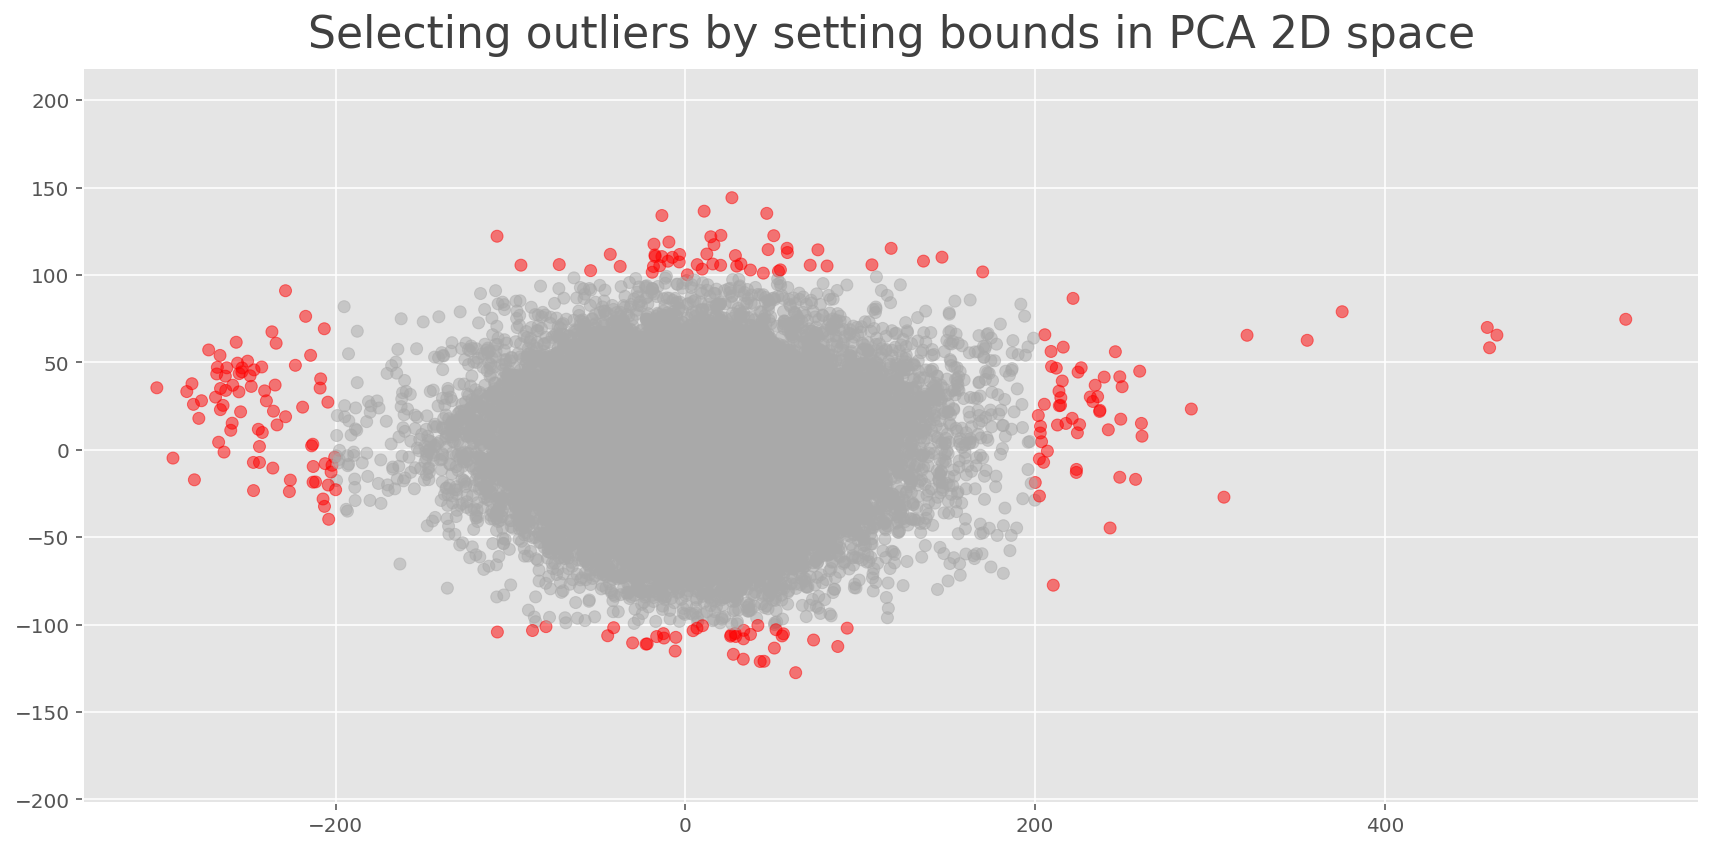

In [12]:
# PCA MFCC to 2 components and plot
pca = PCA(n_components=2, random_state=1)
feat_pca = pca.fit_transform(df_features_train.iloc[:, 5:85])

# get all samples that are beyond than +/- 200 on x and more than +/-100 on y
outliers = np.where((feat_pca[:, 0] >  200) | 
                    (feat_pca[:, 0] < -200) |
                    (feat_pca[:, 1] >  100) | 
                    (feat_pca[:, 1] < -100), True, False)

# drop outliers for a «clean» train and test set
idx_to_drop = df_features_train.loc[outliers].index
meta_clean = df_meta_train.drop(idx_to_drop)
features_clean = df_features_train.drop(idx_to_drop)
meta_clean.reset_index(drop=True, inplace=True)
features_clean.reset_index(drop=True, inplace=True)

outlier_cnt = len(df_meta_train) - len(meta_clean)
outlier_prc = 100 / len(df_meta_train) * outlier_cnt
print(f"{outlier_cnt} outliers ({outlier_prc:.0f}%) selected for removal.")

plt.figure(figsize=(12,6))
plt.scatter(feat_pca[:, 0], feat_pca[:, 1], c=["red" if x==True else "darkgrey" for x in outliers], alpha=.5)    
plt.axis('equal')
plt.title("Selecting outliers by setting bounds in PCA 2D space", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.tight_layout()
plt.show()

In [13]:
print("Training with outliers in MFCC features")
_, _ = train_model(df_features_train.iloc[:, 5:85], df_meta_train.gender, 
                   df_features_test.iloc[:, 5:85], df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False,
                   pca_STFT=False)

print("Training with outliers in MFCC features removed")
_, _ = train_model(features_clean.iloc[:, 5:85], meta_clean.gender, 
                   df_features_test.iloc[:, 5:85], df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False,
                   pca_STFT=False)

Training with outliers in MFCC features
0.932 accuracy crossvalidated 5fold
0.934 accuracy on test set

Training with outliers in MFCC features removed
0.932 accuracy crossvalidated 5fold
0.935 accuracy on test set



- In the EDA I already noticed that **the FO features contain outliers.** 
- Looking at the markerplots of the three most correlated FO features I just could estimate an absolute limit. However, it is obvious that **the outliers are differently distributed in the two classes.** 
- I therefore **separate male and female samples in the test set**, calculate the IQR and **remove all samples beyond 3 times the IQR.**

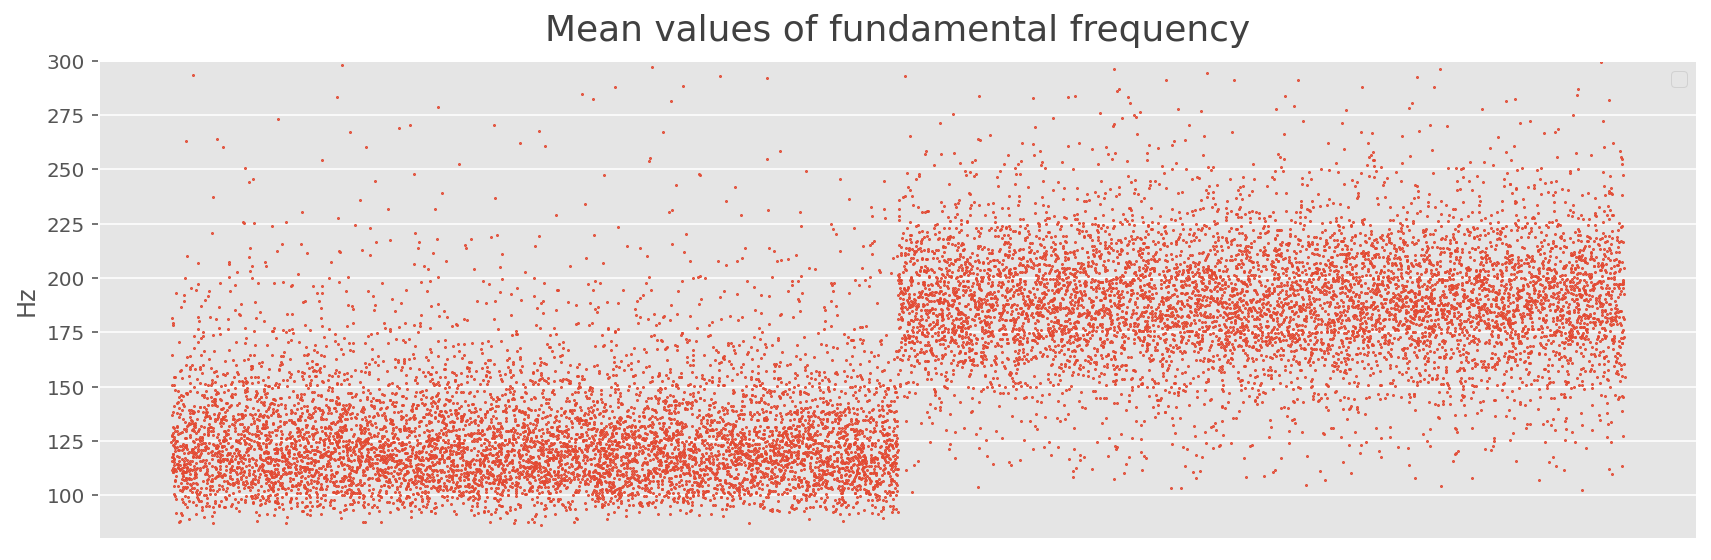

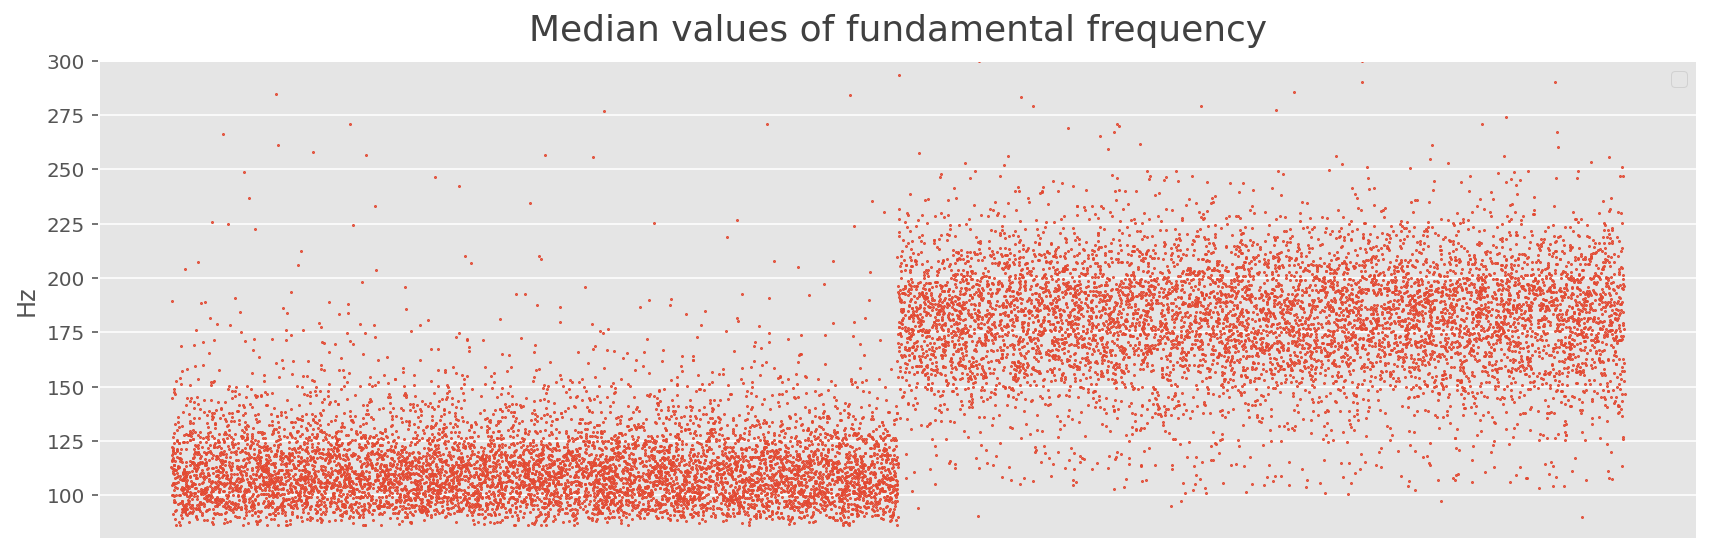

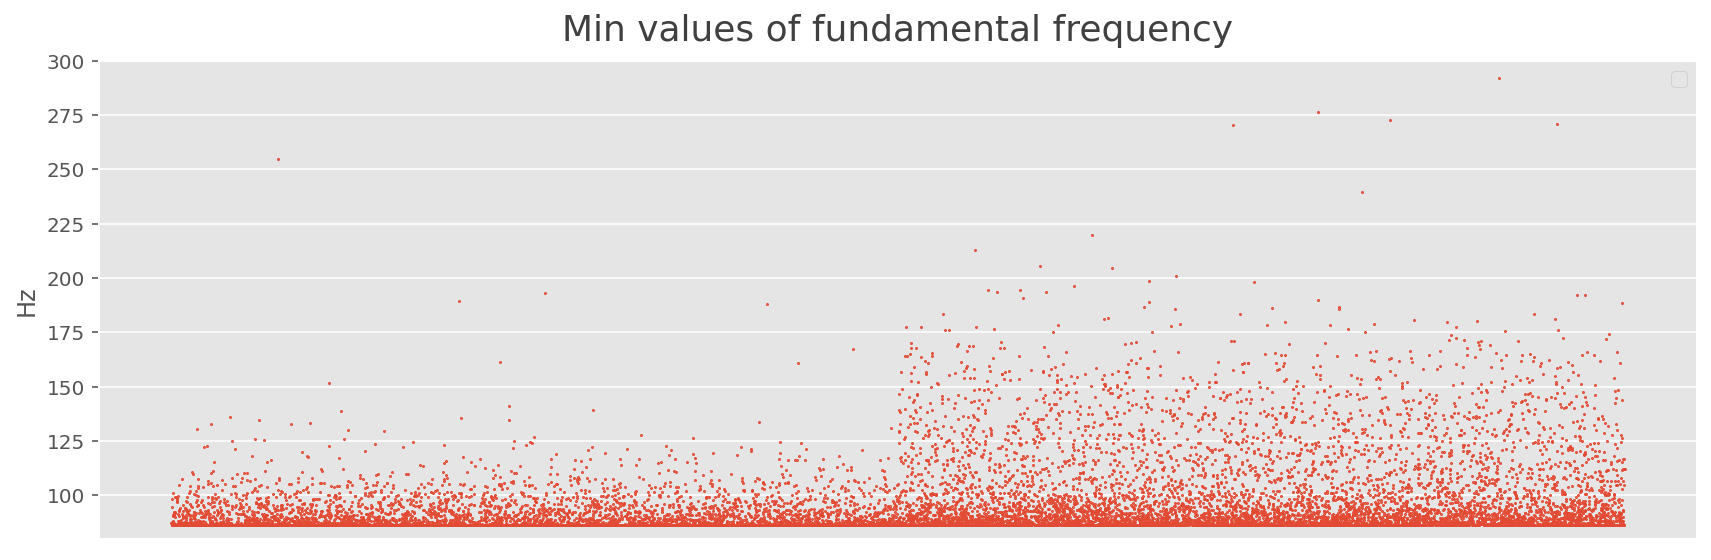

In [14]:
for col in ['fO_mean', 'fO_median', 'fO_min']:
    plt.figure(figsize=(12,4))
    df_features_train[col].iloc[:15033].plot(lw=0, marker='.', markersize=1)
    plt.title(f"{col.replace('fO_','').capitalize()} values of fundamental frequency", size=18, pad=10)
    plt.ylim(80,300)
    plt.xticks([])
    plt.legend([])
    plt.ylabel("Hz")
    plt.tight_layout()
    plt.show()  

In [15]:
cols = ["fO_mean", "fO_median", "fO_min"]
feat_fO = df_features_train.loc[:, cols].copy()
feat_fO_male = feat_fO[np.where(df_meta_train.gender=="male", True, False)]
feat_fO_female = feat_fO[np.where(df_meta_train.gender=="female", True, False)]

idx_to_drop = []
cut_off = 3 # times the IQR

for gender_subset in [feat_fO_male, feat_fO_female]:
    for col in gender_subset.columns:
        q25 = percentile(gender_subset[col], 25)
        q75 = percentile(gender_subset[col], 75)
        iqr = q75 - q25
        lower = q25 - iqr * cut_off
        upper = q75 + iqr * cut_off
        tmp = (gender_subset[(gender_subset[col] < lower) | (gender_subset[col] > upper)].index)
        idx_to_drop.extend(np.array(tmp))

idx_to_drop = set(idx_to_drop)
print(f"Found {len(idx_to_drop)} ({100/len(df_features_train)*len(idx_to_drop):.2f}%) outliers by setting bounds at {cut_off} times the IQR.")

Found 1767 (5.88%) outliers by setting bounds at 3 times the IQR.


In [16]:
features_clean = df_features_train.drop(idx_to_drop)
meta_clean = df_meta_train.reindex(features_clean.index)
meta_clean.reset_index(drop=True, inplace=True)
features_clean.reset_index(drop=True, inplace=True)

outlier_cnt = len(df_meta_train) - len(meta_clean)
outlier_prc = 100 / len(df_meta_train) * outlier_cnt

- Removing the outliers in the three important FO features **improves accuracy crossvalidated but degrades accuracy on the test set.**
- By removing outliers from the training set and then crossvalidating on the same data **I have introduced a data leakage.** I am «not allowed to know» the outliers in the validation data of the various folds. The proper way would be to integrate outlier removal in the scikit pipeline. In addition I likely have removed possibly harder to predict samples and therefore get a better result on the crossvalidated score.
- I suspect that the identified outliers actually help the model to better generalize to the variety of voices and utterances. I therefore decide not to remove FO outliers.

In [17]:
print("Training with outliers in FO features")
_, _ = train_model(df_features_train.loc[:, cols], df_meta_train.gender, 
                   df_features_test.loc[:, cols], df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False,
                   pca_STFT=False)

print("Training with outliers in FO features removed")
_, _ = train_model(features_clean.loc[:, cols], meta_clean.gender, 
                   df_features_test.loc[:, cols], df_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False,
                   pca_STFT=False)

Training with outliers in FO features
0.935 accuracy crossvalidated 5fold
0.938 accuracy on test set

Training with outliers in FO features removed
0.954 accuracy crossvalidated 5fold
0.929 accuracy on test set



### Training with log scaled FO features
- **Training with log scaled FO features results in a slightly improved accuracy** (+0.005 on test set).

Since the difference is so subtle I decide to not log transform the data.

In [18]:
def train_log_transformed(log_transform=True):
    logtransformer = FunctionTransformer(np.log1p)
    if log_transform==True:
        pipe = make_pipeline(logtransformer, StandardScaler(), LogisticRegression(max_iter=MAX_ITER))   
    else:
        pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=MAX_ITER))   
    scores = cross_val_score(pipe, df_features_train.iloc[:, :5], df_meta_train.gender, n_jobs=-1)
    print(f"{np.mean(scores):.3f} accuracy crossvalidated")
    pipe.fit(df_features_train.iloc[:, :5], df_meta_train.gender)
    y_pred = pipe.predict(df_features_test.iloc[:, :5])
    print(f"{accuracy_score(df_meta_test.gender, y_pred):.3f} accuracy on test set")

In [19]:
print("Training FO features")
train_log_transformed(False)
print()

print("Training FO features log transformed")
train_log_transformed(True)

Training FO features
0.934 accuracy crossvalidated
0.936 accuracy on test set

Training FO features log transformed
0.937 accuracy crossvalidated
0.939 accuracy on test set


## Training and predicting across languages
**A model trained on German samples can predict French, Italian and Romansh audio just a little less accurately** (-.01 to -.03 decrease of accuracy).

In [20]:
print("Model trained in German, prediction on French")
_, _ = train_model(feat_gr.iloc[:, :85], meta_gr.gender, 
                   feat_fr.iloc[:, :85], meta_fr.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False,
                   pca_STFT=False)

print("Model trained in German, prediction on Italian")
_, _ = train_model(feat_gr.iloc[:, :85], meta_gr.gender, 
                   feat_it.iloc[:, :85], meta_it.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False,
                   pca_STFT=False)

print("Model trained in German, prediction on Romansh")
_, _ = train_model(feat_gr.iloc[:, :85], meta_gr.gender, 
                   feat_ro.iloc[:, :85], meta_ro.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False,
                   pca_STFT=False)

Model trained in German, prediction on French
0.949 accuracy crossvalidated 5fold
0.936 accuracy on test set

Model trained in German, prediction on Italian
0.949 accuracy crossvalidated 5fold
0.940 accuracy on test set

Model trained in German, prediction on Romansh
0.949 accuracy crossvalidated 5fold
0.915 accuracy on test set



## Training and predicting multilingual
- **A model trained on German, French, Italian and Romansh can predict on multilingual samples.** This is promising since I want to predict on podcasts that contain German and Swissgerman (not a different language per se but different dialect nonetheless). 
- Prediction works astonishingly well even for «extra hard» samples from unique voices the model hasn't «heard» in training at all. 

In [21]:
all_meta = pd.concat([meta_gr, meta_fr, meta_it, meta_ro]).reset_index(drop=True)
all_features = pd.concat([feat_gr.iloc[:, :85], feat_fr.iloc[:, :85], 
                          feat_it.iloc[:, :85], feat_ro.iloc[:, :85]]).reset_index(drop=True)

# creating an «extra hard» test set with all samples from contributors who have made 10 or less recordings
tmp = all_meta.client_id.value_counts().sort_values()
tmp = tmp[tmp<=10]
idx = all_meta[all_meta.client_id.isin(tmp.index)].index
all_meta_test = all_meta.loc[idx]
all_features_test = all_features.loc[idx]
all_meta.drop(idx, inplace=True)
all_features.drop(idx, inplace=True)

all_meta_test.reset_index(drop=True, inplace=True)
all_features_test.reset_index(drop=True, inplace=True)
all_meta.reset_index(drop=True, inplace=True)
all_features.reset_index(drop=True, inplace=True)

_, _ = train_model(all_features, all_meta.gender, 
                   all_features_test, all_meta_test.gender, 
                   clf=LogisticRegression(max_iter=MAX_ITER), 
                   report=False,
                   pca_STFT=False)

0.946 accuracy crossvalidated 5fold
0.944 accuracy on test set



## Unsupervised training with KMeans
In a next experiment I try to **find the gender labels unsupervised with `KMeans`**.
- **This works astonishingly well** and yields an accuracy of 0.90.
- I can imagine making use of this to create more training samples, e.g. from Swissgerman podcast episodes where I have no labels but could quickly classify the data with KMeans and then manually check for errors.

In [22]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(feat_gr.iloc[:, :85])
# I didn't observe any improvement by PCA'ing the features to less dimensions for KMeans
# pca = PCA(n_components=len(feat_gr.columns), random_state=3)
# X = pca.fit_transform(X)

km = KMeans(n_clusters=2, random_state=2)
km.fit(X)
meta_gr["km_labels"] = km.labels_
meta_gr.km_labels = np.where(meta_gr.km_labels==1, True, False)
meta_gr["true_preds"] = meta_gr.man == meta_gr.km_labels
accuracy_kmeans = meta_gr.true_preds.sum() / len(meta_gr)
print(f"Unsupervised training with KMeans yields {accuracy_kmeans:.2f} accuracy.")

Unsupervised training with KMeans yields 0.90 accuracy.


# 2) Conclusions
- **The extracted features clearly work for gender classification.**
- Even an untuned logistic regressor already yields good results.
- **FO and MFCC are strong predictors for gender.**
- **STFT doesn't seem to bring benefits.**
- **Outlier removal doesn't improve or even degrades accuracy.**
- Log scaling FO features does improve accuracy very slightly.
- **Prediction works across languages with only slight loss of accuracy.** That is promising in regard to Swissgerman prediction.

**Decisions for next steps based on all findings**
- I will use FO and MFCC as features. 
- I will drop STFT features.
- I won't remove outliers.
- I won't log scale FO features.